In [180]:
#build the database

import pandas as pd
df = pd.read_parquet("hf://datasets/tattabio/e_coli_rnas/data/train-00000-of-00001.parquet")
df['seq_id'] = [f"seq_{i}" for i in range(len(df))]
with open("/Users/liuyajie/Projects/project-env/690/cluster/seqs.fasta", "w") as f:
    for i, row in df.iterrows():
        f.write(f">{row['seq_id']}\n{row['Sequence']}\n")

!makeblastdb -in /Users/liuyajie/Projects/project-env/690/cluster/seqs.fasta -dbtype nucl -out /Users/liuyajie/Projects/project-env/690/cluster/seqs_db




Building a new DB, current time: 05/07/2025 02:48:09
New DB name:   /Users/liuyajie/Projects/project-env/690/cluster/seqs_db
New DB title:  /Users/liuyajie/Projects/project-env/690/cluster/seqs.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /Users/liuyajie/Projects/project-env/690/cluster/seqs_db
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 161 sequences in 0.00335002 seconds.




In [ ]:
#generate hyperparameter combinations
import numpy as np

evalue_thresholds = np.logspace(np.log10(1e-8), np.log10(100), num=20)
word_sizes = list(range(4, 20))
distance_methods = ['pident', 'evalue', 'bitscore']

query_file = "/Users/liuyajie/Projects/project-env/690/cluster/seqs.fasta"
db_name = "/Users/liuyajie/Projects/project-env/690/cluster/seqs_db"
blast_output = "/Users/liuyajie/Projects/project-env/690/cluster/blast_temp.tsv"
true_labels = df['Label'].tolist()


In [107]:
from sklearn.cluster import SpectralClustering
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
results = []
for word_size in word_sizes:
    for evalue_thresh in evalue_thresholds:

        blast_cmd = f"blastn -query {query_file} -db {db_name} -word_size {word_size} -evalue {evalue_thresh} -outfmt 6 -out {blast_output}"
        os.system(blast_cmd)

   
        if os.path.getsize(blast_output) == 0:
            continue
        cols = ['qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore']
        df_read = pd.read_csv(blast_output, sep="\t", names=cols)
        seq_ids = sorted(set(df_read['qseqid']) | set(df_read['sseqid']))
        
        
        for metric in distance_methods:
            if metric =='evalue':
                F = pd.DataFrame(evalue_thresh, index=seq_ids, columns=seq_ids)
                agg_func='min'
            else:
                F = pd.DataFrame(0.0, index=seq_ids, columns=seq_ids)
                agg_func = 'max' 
            
            grouped = df_read.groupby(['qseqid', 'sseqid'])[metric].agg(agg_func).reset_index()


            for _, row in grouped.iterrows():
                q, s, val = row['qseqid'], row['sseqid'], row[metric]
                F.at[q, s] = val
                F.at[s, q] = val  # 对称填充
            

    
            X=F.values
            n_clusters = len(set(true_labels))
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            pred_labels = kmeans.fit_predict(X)
            

            vscore = v_measure_score(true_labels, pred_labels)

            results.append({
                    'word_size': word_size,
                    'evalue_thresh': evalue_thresh,
                    'metric': metric,
                    'v_measure': vscore
                
            })


results_df = pd.DataFrame(results)
top3 = results_df.sort_values(by='v_measure', ascending=False).head(100)
print("\nTop 3 parameter combinations by V-measure:")
print(top100.to_string(index=False))



Top 3 parameter combinations by V-measure:
 word_size  evalue_thresh metric  v_measure
         7   5.455595e-04 evalue   0.272270
         8   5.455595e-04 evalue   0.272270
         9   5.455595e-04 evalue   0.272270
         8   4.832930e-05 evalue   0.260418
        10   4.832930e-05 evalue   0.260418
         7   1.438450e-05 pident   0.260418
         7   1.438450e-05 evalue   0.260418
        10   1.438450e-05 pident   0.260418
        10   4.832930e-05 pident   0.260418
        10   1.623777e-04 evalue   0.260418
         7   4.281332e-06 pident   0.260418
         7   4.832930e-05 pident   0.260418
         7   4.832930e-05 evalue   0.260418
         5   4.281332e-06 pident   0.260418
        11   4.832930e-05 pident   0.260418
         8   4.832930e-05 pident   0.260418
         7   4.281332e-06 evalue   0.260418
         7   3.792690e-07 pident   0.260418
         8   1.438450e-05 pident   0.260418
         7   1.128838e-07 pident   0.260418
         9   3.792690e-07 pident

In [102]:
results_df.to_csv('/Users/liuyajie/Projects/project-env/690/cluster/vmeasure_results_long.csv', index=False)

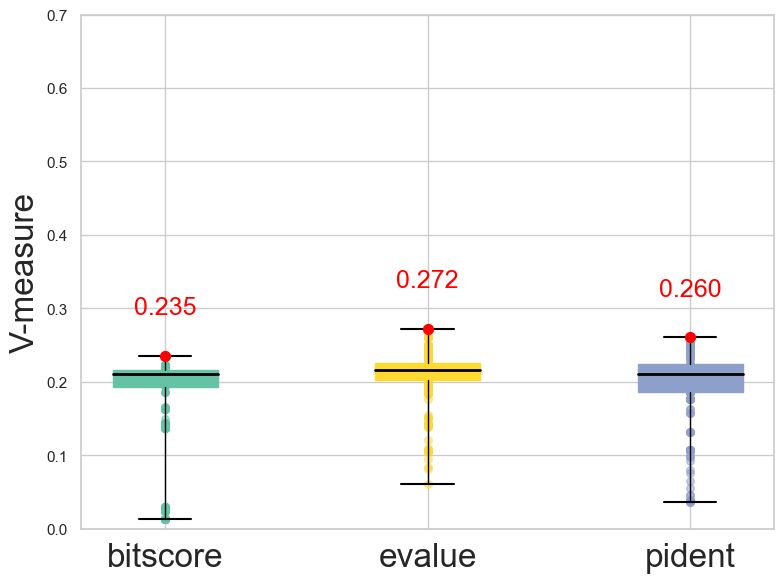

In [178]:
#Summarize the performance of BLAST
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('/Users/liuyajie/Projects/project-env/690/cluster/vmeasure_results_long.csv')


plt.figure(figsize=(8, 6))
metrics = sorted(df['metric'].unique())
positions = range(len(metrics))
colors = ['#66c2a5', '#ffd92f', '#8da0cb']


for i, (metric, color) in enumerate(zip(metrics, colors)):
    data = df[df['metric'] == metric]['v_measure']
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    median = data.median()
    vmin = data.min()
    vmax = data.max()


    plt.scatter([i]*len(data), data, color=color, alpha=0.5, s=30)


    plt.gca().add_patch(plt.Rectangle((i - 0.2, q1), 0.4, q3 - q1,
                                      fill=True, color=color, edgecolor='black'))


    plt.plot([i - 0.2, i + 0.2], [median, median], color='black', linewidth=2)


    plt.plot([i, i], [vmin, q1], color='black', linewidth=1)
    plt.plot([i, i], [q3, vmax], color='black', linewidth=1)


    plt.plot([i - 0.1, i + 0.1], [vmin, vmin], color='black')
    plt.plot([i - 0.1, i + 0.1], [vmax, vmax], color='black')

best_scores = df.groupby('metric')['v_measure'].max().reset_index()


for i, row in best_scores.iterrows():
    plt.scatter(x=row['metric'], y=row['v_measure'], color='red', zorder=10,s=50)
    plt.text(i, row['v_measure'] + 0.05, f"{row['v_measure']:.3f}",
             ha='center', va='bottom', fontsize=18, color='red')

plt.xticks(positions, metrics,fontsize=24)
plt.ylabel("V-measure",fontsize=24)

plt.ylim(0, 0.7)

plt.tight_layout()
plt.show()


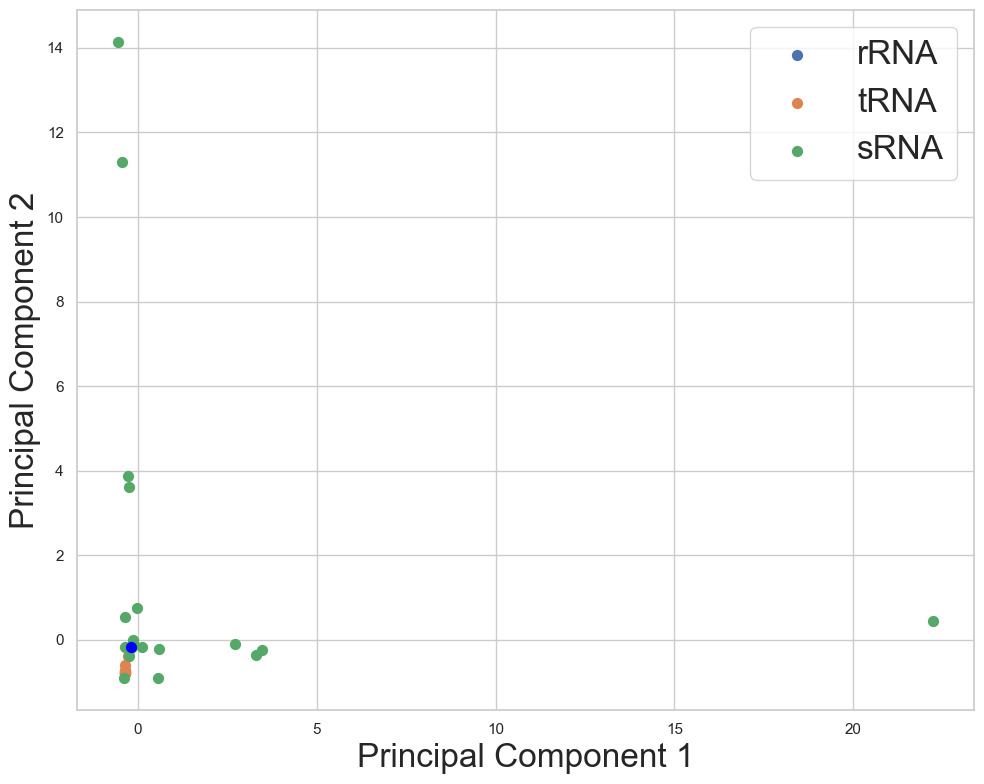

In [181]:
#Visualize the true labels
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2)
principal_components = pca.fit_transform(F_scaled)


pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'], index=F.index)


seqid_to_label = dict(zip(df['seq_id'], df['Label']))
pca_df['label'] = pca_df.index.map(seqid_to_label)

plt.figure(figsize=(10, 8))
for label in pca_df['label'].unique():
    subset = pca_df[pca_df['label'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label, s=50)
plt.scatter(x=-0.195824, y=-0.165249, color='blue',s=50)
plt.xlabel('Principal Component 1',fontsize=24)
plt.ylabel('Principal Component 2',fontsize=24)

plt.legend(fontsize=24)
plt.grid(True)
plt.tight_layout()
plt.show()


In [182]:
X=F.values
n_clusters = len(set(true_labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pred_labels = kmeans.fit_predict(X)
pca_df['predicted_label'] = pred_labels

In [183]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(pca_df)


               PC1        PC2 label  predicted_label
seq_0    -0.195824  -0.165249  rRNA                0
seq_1    -0.195824  -0.165249  rRNA                0
seq_10   -0.195824  -0.165249  tRNA                0
seq_100  -0.195824  -0.165249  sRNA                0
seq_101  -0.195824  -0.165249  sRNA                0
seq_102  -0.195824  -0.165249  sRNA                0
seq_103  -0.195824  -0.165249  sRNA                0
seq_104  -0.195824  -0.165249  sRNA                0
seq_105  -0.195824  -0.165249  sRNA                0
seq_106  -0.195824  -0.165249  sRNA                0
seq_107  -0.195824  -0.165249  sRNA                0
seq_108  -0.195824  -0.165249  sRNA                0
seq_109  -0.195824  -0.165249  sRNA                0
seq_11   -0.136329  -0.092913  tRNA                0
seq_110  -0.195824  -0.165249  rRNA                0
seq_111  -0.347457  -0.746171  rRNA                0
seq_112  -0.195824  -0.165249  rRNA                0
seq_113  -0.195824  -0.165249  rRNA           

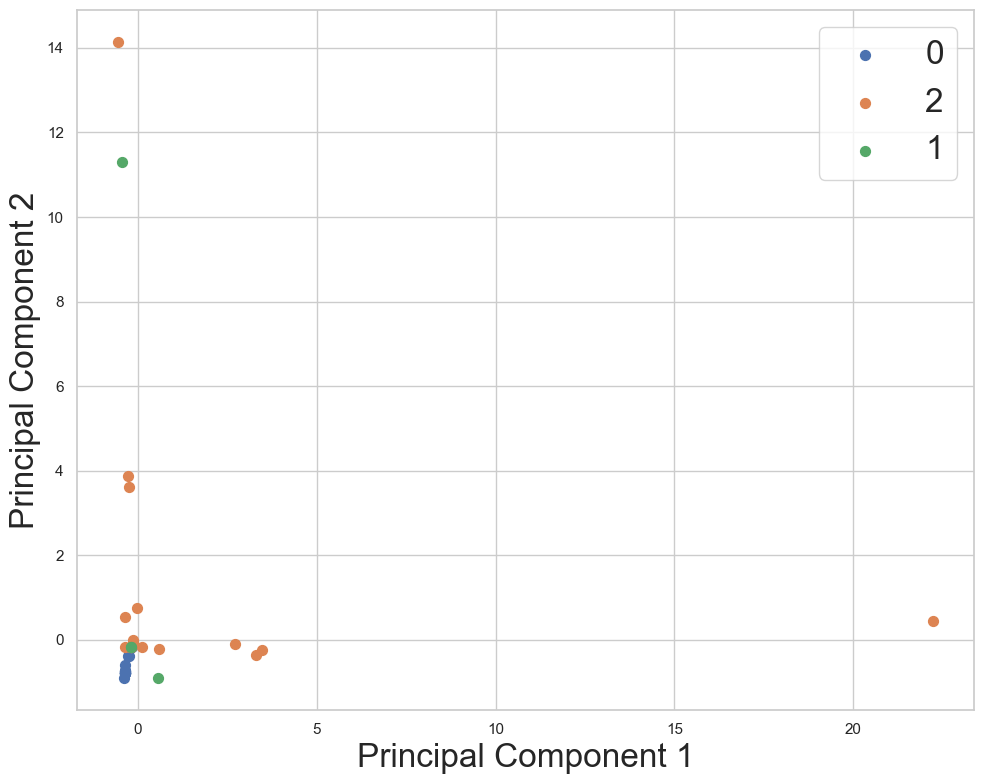

In [185]:
#Visualize the predicted results

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt




plt.figure(figsize=(10, 8))
for label in pca_df['predicted_label'].unique():
    subset = pca_df[pca_df['predicted_label'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label, s=50)

plt.xlabel('Principal Component 1',fontsize=24)
plt.ylabel('Principal Component 2',fontsize=24)

plt.legend(fontsize=24)
plt.grid(True)
plt.tight_layout()
plt.show()
